In [31]:
from feature_engineering import generate_features
from get_data import get_raw_data
import pandas as pd
from feature_engineering import get_sp_500_data

In [32]:

from feature_engineering import add_original_feature_return


data=pd.DataFrame()

data=add_original_feature_return(get_raw_data('TSLA'),data)
data=data.dropna()

[*********************100%%**********************]  1 of 1 completed


In [33]:
data.head(-10)


,open,open_1,close,high_1,low_1,volume_1
Date,,,,,,
2019-09-11,15.825333,15.386667,15.702667,15.702667,15.262667,73255500.0
2019-09-12,16.513332,15.825333,16.473333,16.544666,15.733333,150642000.0
2019-09-13,16.464001,16.513332,16.391333,16.900000,16.293333,128718000.0
2019-09-16,16.400000,16.464001,16.346666,16.563334,16.324667,79696500.0
2019-09-17,16.164667,16.400000,16.187332,16.495333,16.077999,70921500.0
...,...,...,...,...,...,...
2024-04-17,157.639999,156.740005,157.110001,158.190002,153.750000,97000000.0
2024-04-18,151.250000,157.639999,155.449997,158.330002,153.779999,82439700.0
2024-04-19,148.970001,151.250000,149.929993,152.199997,148.699997,96098800.0


In [34]:
data.shape

(1172, 6)

In [35]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.models import Sequential
from keras.layers import  LSTM, Dense,Dropout


In [36]:
from datetime import datetime
from packaging import version

from tensorflow import keras
from keras import backend as K



print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.15.0


In [37]:
# here we are seperating the data 
trainning_set = data[:'2024-03-01'].iloc[:,1:2].values
test_set = data['2024-03-01':].iloc[:,1:2].values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(trainning_set)


X_train = []
Y_train = []


for i in range(1, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-1:i, 0])
    Y_train.append(training_set_scaled[i, 0])

X_train = X_train[-621:] # same size of data neeeded
Y_train = Y_train[-621:] # same size of data neeeded

# Convert lists to NumPy arrays
X_train, y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train for LSTM input shape (batch_size, timesteps, input_dim)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [38]:
X_train.shape

(621, 1, 1)

In [39]:

# pre-processing the data 
dataset_total = pd.concat((data["close"][:'2024-03-01'],data["close"]['2024-03-01':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 500:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

# making the test data
X_test = []
for i in range(500,len(inputs)):
  X_test.append(inputs[i-1:i,0])

X_test_no_shape = np.array(X_test)
X_test = np.reshape(X_test_no_shape, (X_test_no_shape.shape[0],X_test_no_shape.shape[1],1))


test_set=scaler.transform(test_set)

test_set.shape

(47, 1)

In [40]:
def mae(y_predicted, y_true):
    total_error = 0
    for yp, yt in zip(y_predicted, y_true):
        total_error += abs(yp - yt)
    
    mae = total_error/len(y_predicted)
    
    return mae

Best h-params : DROP [0.3,0.1,0.1,0.1] UNITS[32,32,64,32]

In [41]:
model = Sequential()

model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64))
model.add(Dropout(0.2))

model.add(Dense(units=64))
model.add(Dropout(0.2))

model.add(Dense(units=42))
model.add(Dropout(0.2))

model.add(Dense(units=1))


METRICS = [
    keras.metrics.MeanAbsoluteError(name='mae'),
    tf.keras.metrics.RootMeanSquaredError(name='rmse'),
    keras.metrics.MeanSquaredError(name='mse'),
]
                        
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=METRICS)

tf.random.set_seed(21)





logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")+"no_feature_eng"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


callback = keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True)

model.fit(X_train, y_train, epochs=100,batch_size=32,callbacks=[callback,tensorboard_callback]) 
loss = model.evaluate(X_test, test_set)

Epoch 1/100
20/20 [==============================] - 3s 6ms/step - loss: 0.1403 - mae: 0.3126 - rmse: 0.3746 - mse: 0.1403
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0298 - mae: 0.1389 - rmse: 0.1727 - mse: 0.0298
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0247 - mae: 0.1271 - rmse: 0.1571 - mse: 0.0247
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0216 - mae: 0.1186 - rmse: 0.1469 - mse: 0.0216
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0167 - mae: 0.1030 - rmse: 0.1294 - mse: 0.0167
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0116 - mae: 0.0863 - rmse: 0.1075 - mse: 0.0116
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0068 - mae: 0.0626 - rmse: 0.0824 - mse: 0.0068
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0071 - mae: 0.0635 - rmse: 0.0840 - mse: 0.0071
Epoch 9/100
20/2

In [42]:
predicted_stock_price = model.predict(X_test)

predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
test_set=scaler.inverse_transform(test_set)

2/2 [==============================] - 1s 3ms/step


In [43]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

print(f"MSE: {mean_squared_error(test_set,predicted_stock_price)}")
print(f"MRSE: {mean_absolute_error(test_set,predicted_stock_price)}")
print(f"R^2: {r2_score(test_set,predicted_stock_price)}")
print(f"MAE{mean_absolute_error(test_set,predicted_stock_price)}")

MSE: 30.077699375031713
MRSE: 3.8913249563663563
R^2: 0.818269493608726
MAE3.8913249563663563


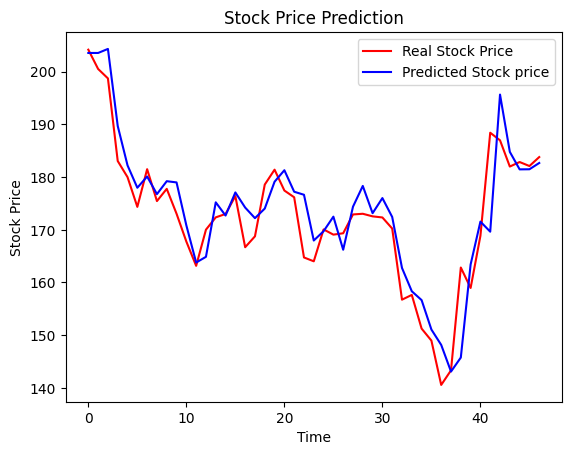

In [44]:
import matplotlib.pyplot as plt

def plot_prediction(test,prediction):
    plt.plot(test,color='red',label="Real Stock Price")
    plt.plot(prediction, color="blue",label="Predicted Stock price")
    plt.title("Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()


plot_prediction(test_set,predicted_stock_price)

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 128)            66560     
                                                                 
 dropout_10 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_7 (LSTM)               (None, 1, 128)            131584    
                                                                 
 dropout_11 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)               